In [ ]:
import sys; sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np

from src.utils import test_stationarity, test_autocorr_specific_lag, test_variance_trend

In [2]:
# makes the plots readable

plt.rcParams.update({
   'font.size': 12,
   'axes.labelsize': 12,
   'axes.titlesize': 14,
   'xtick.labelsize': 11,
   'ytick.labelsize': 11,
   'legend.fontsize': 11
})

In [3]:
df = pd.read_csv('../data/processed/merged_data.csv', index_col=0, parse_dates=True)

df = df.replace(['empty', 'n/e'], pd.NA)
df = df.apply(pd.to_numeric, errors='coerce')

/var/folders/ck/lznm59f955s3z8lzdpb1sw840000gp/T/ipykernel_77404/4214698959.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/merged_data.csv', index_col=0, parse_dates=True)


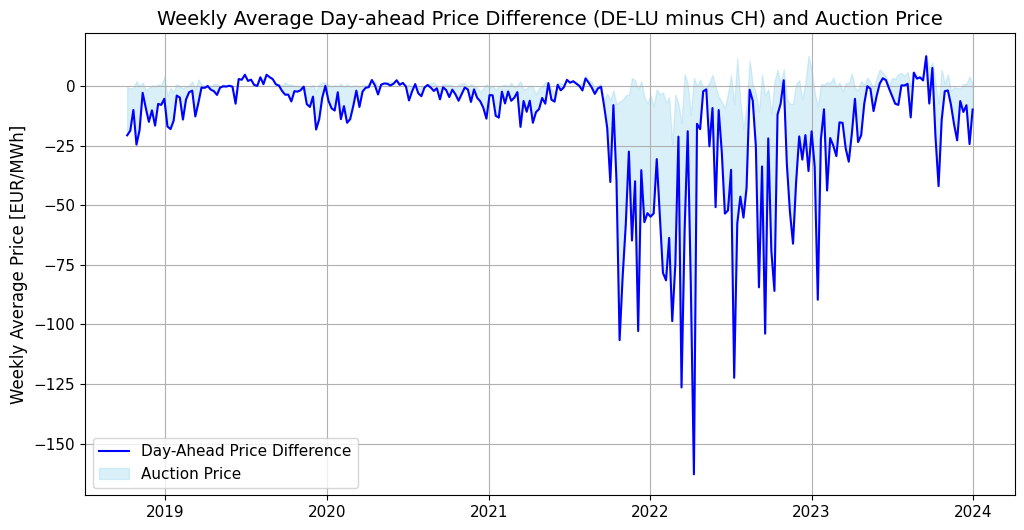

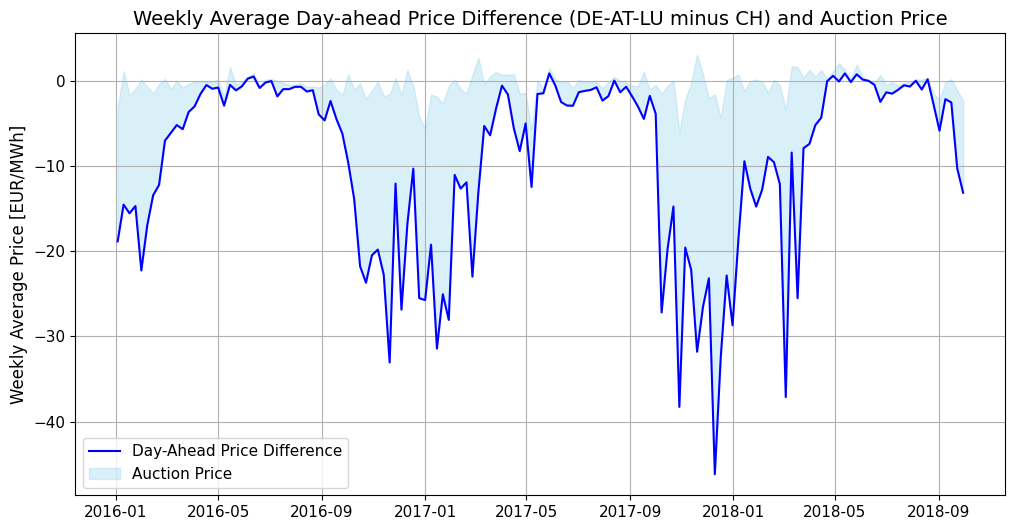

In [4]:
# Calculate Weekly averages for prices and auction data
weekly_df = df.resample('W').mean()

# Calculate price differences 
weekly_df['DE-LU_minus_CH'] = weekly_df['DE-LU'] - weekly_df['CH']
weekly_df['DE-AT-LU_minus_CH'] = weekly_df['DE-AT-LU'] - weekly_df['CH']

plt.figure(figsize=(12, 6))

# Plot DE-LU minus CH price difference
plt.plot(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

# Fill between price difference and auction price
plt.fill_between(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   weekly_df['DE-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)
plt.show()

# Same plot for DE-AT-LU
plt.figure(figsize=(12, 6))
plt.plot(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

plt.fill_between(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   weekly_df['DE-AT-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-AT-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate error series
df_starting_2019 = df.loc['2019-01-01':]
df_starting_2019.loc[:, 'error'] = (df_starting_2019['CH'] - 
                                   df_starting_2019['DE-LU'] - 
                                   df_starting_2019['de-ch_auctionPrice'])

# 1. Test stationarity (ADF test)
stationarity_results = test_stationarity(df_starting_2019['error'])

# Fit constant model and use HAC standard errors
X = np.ones(len(df_starting_2019['error'].dropna()))
y = df_starting_2019['error'].dropna()
model = sm.OLS(y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 192})
print(f"HAC t-statistic: {results.tvalues[0]:.4f}")
print(f"HAC p-value: {results.pvalues[0]:.4f}")


# 3. Test autocorrelation at lag 192
autocorr_results = test_autocorr_specific_lag(df_starting_2019['error'], 192)

# 4. Test if normalized variance is increasing
variance_trend_results = test_variance_trend(df_starting_2019)

# Print results
print("Stationarity Test:")
print(f"ADF Statistic: {stationarity_results['adf_stat']:.4f}")
print(f"P-value: {stationarity_results['p_value']:.4f}")

print("\nMean Zero Test:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

print("\nAutocorrelation Test (Lag 192):")
print(f"ACF: {autocorr_results['acf']:.4f}")
print(f"Z-statistic: {autocorr_results['z_stat']:.4f}")
print(f"P-value: {autocorr_results['p_value']:.4f}")

print("\nVariance Trend Test:")
print(f"Slope: {variance_trend_results['slope']:.4e}")
print(f"P-value: {variance_trend_results['p_value']:.4f}")
print(f"R-squared: {variance_trend_results['r_squared']:.4f}")

/var/folders/ck/lznm59f955s3z8lzdpb1sw840000gp/T/ipykernel_77404/1728973091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starting_2019.loc[:, 'error'] = (df_starting_2019['CH'] -


Stationarity Test:
ADF Statistic: -26.1052
P-value: 0.0000

Mean Zero Test:
T-statistic: -0.8299
P-value: 0.4066

Autocorrelation Test (Lag 192):
ACF: 0.0647
Z-statistic: 13.5365
P-value: 0.0000

Variance Trend Test:
Slope: 2.7606e-05
P-value: 0.2920
R-squared: 0.0000


/Users/research/Desktop/repos/electricity-price-disparity-ch-de/notebooks/../src/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_price'] = (df['CH'] + df['DE-LU'])/2
/Users/research/Desktop/repos/electricity-price-disparity-ch-de/notebooks/../src/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_error'] = df['error']/df['avg_price']


/var/folders/ck/lznm59f955s3z8lzdpb1sw840000gp/T/ipykernel_77404/927364079.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_error = df_starting_2019['error'].resample('H').mean()


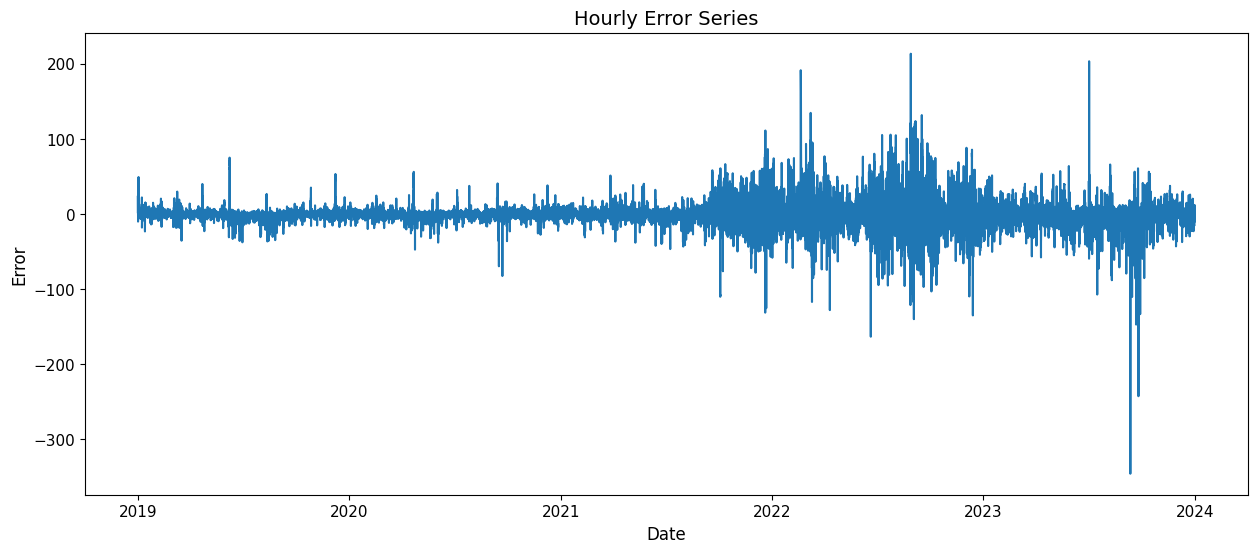

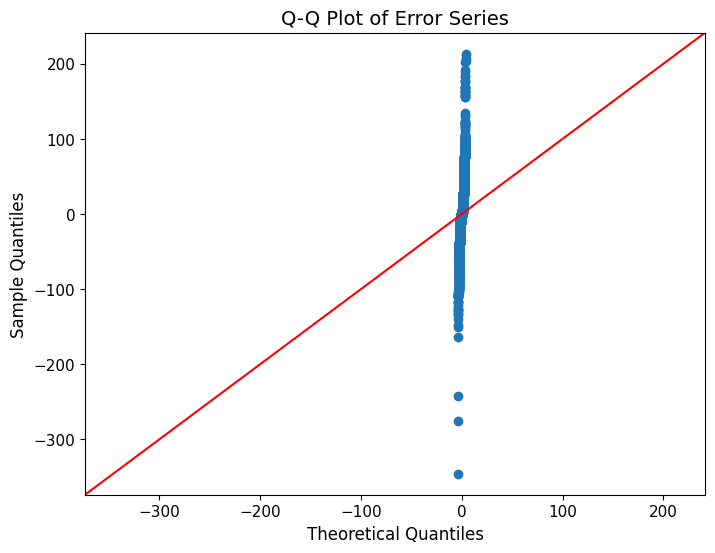

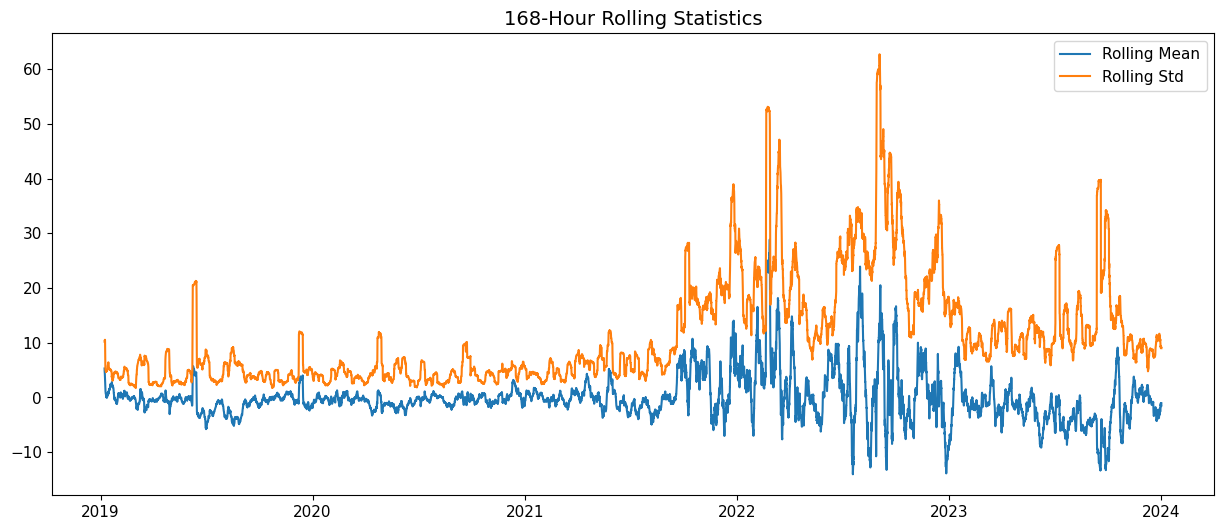

In [7]:
# Handle missing values and create visualizations
hourly_error = df_starting_2019['error'].resample('H').mean()
hourly_error_clean = hourly_error.interpolate()

# Basic time series plot
plt.figure(figsize=(15, 6))
plt.plot(hourly_error_clean)
plt.title('Hourly Error Series')
plt.xlabel('Date')
plt.ylabel('Error')

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.qqplot(df_starting_2019['error'].dropna(), line='45', ax=ax)
plt.title('Q-Q Plot of Error Series')

# Rolling statistics
window = 24*7  # One week
rolling_mean = hourly_error_clean.rolling(window=window).mean()
rolling_std = hourly_error_clean.rolling(window=window).std()

plt.figure(figsize=(15, 6))
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.title(f'{window}-Hour Rolling Statistics')
plt.legend()
plt.show()

In [ ]:
# Calculate hourly price difference
df['CH_minus_DE'] = df['CH'] - df['DE-LU']

# Analyze error distribution
error = df['CH_minus_DE'] - df['de-ch_auctionPrice']
plt.figure(figsize=(12, 6))
plt.hist(error.dropna(), bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Error [EUR/MWh]')
plt.ylabel('Frequency')
plt.title('Error Distribution (CH - DE minus Auction Price)')
plt.grid(True)
plt.show()

# Analyze variance at different times of the day
df['hour'] = df.index.hour
hourly_variance = df.groupby('hour')['CH_minus_DE'].var()

plt.figure(figsize=(12, 6))
plt.plot(hourly_variance.index, hourly_variance, marker='o', linestyle='-', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Variance [EUR^2/MWh^2]')
plt.title('Variance of Hourly Price Difference (CH - DE) by Hour of the Day')
plt.grid(True)
plt.show()